# Green-Ampt infiltration model 
## M. Vanclooster 16/03/2018

In this section, we are going to evaluate the Green-Ampt infiltration model. 

We start again by definining the soil hydraulic functions. For a given initial pressure head, or equivalently, an initial water content, we estimate also the pressure head at the wetting front as follows:

\begin{equation}
    h_f=\frac{1}{ks}\int_{0}^{hi} k(h) dh =\frac{1}{ks}\int_{\theta_s}^{\theta_i} D(\theta) d\theta
\end{equation}

Note, the pressure head in this case is negative!

In [95]:
import os
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve

%matplotlib inline

def vgmod(ths,thr,alfa,n,h):
    hp=np.abs(h)
    m=1-1/n
    th=thr+(ths-thr)/(1+(alfa*hp)**n)**m
    return th

def integrand_cond(h,ths,thr,alfa,n,ks,lam):
    hp=np.abs(h)
    m=1-1/n
    th=thr+(ths-thr)/(1+(alfa*hp)**n)**m
    se=(th-thr)/(ths-thr)
    return ks*se**(lam)*( 1-( 1-se**(1/m)))**2 

def integrand_dif(th,ths,thr,alfa,n,ks,lam):
    m=1-1/n
    se=(th-thr)/(ths-thr)
    h=((se**(-1/m)-1)**(1/n))/alfa
    c=-n*(alfa*h)**n*(-1 + 1/n)*(-thr + ths)*((alfa*h)**n + 1)**(-1 + 1/n)/(h*((alfa*h)**n + 1))
    k=ks*se**(lam)*( 1-( 1-se**(1/m)))**2 
    return k/c

# Parl equation to be checked. If thi->ths than term becomes negative: Error in form
#def integrand_parl(h,hi,ths,thr,alfa,n,ks,lam):
#    m=1-1/n
#   th=thr+(ths-thr)/(1+(alfa*h)**n)**m
#    thi=thr+(ths-thr)/(1+(alfa*hi)**n)**m
#    se=(th-thr)/(ths-thr)
#    k=ks*se**(lam)*( 1-( 1-se**(1/m)))**2 
#    term=(ths-th-2*thi)/(ths-thi)
#    return (ths-th-2*thi)


theta_s=0.4
theta_r=0.05
alfa=0.001 #(1/cm)
n=1.7
lamda=0.5
ks=10#  (cm/day)
    
pf = np.arange(0, 7, 0.1)
h = -10**pf
hi = -10000
th= vgmod(theta_s,theta_r,alfa,n,h)
thi= vgmod(theta_s,theta_r,alfa,n,hi)

# First option (integrand via conductivity equation)
inte_1=np.asarray(quad(integrand_cond,0,hi, args=(theta_s,theta_r,alfa,n,ks,lamda)))
hf_1=inte_1[0]/ks

# Second option (integrand via diffusivity equation)
inte_2=np.asarray(quad(integrand_dif,theta_s,thi, args=(theta_s,theta_r,alfa,n,ks,lamda)))
hf_2=inte_2[0]/ks

# Third option (integrand via Parl equation)
# inte_3=np.asarray(quad(integrand_parl,0,hi, args=(hi,theta_s,theta_r,alfa,n,ks,lamda)))
# hf_3= inte_3[0]/2


Just for fun, let's compare the difference between the initial suction head and the evaluated suction head at the wetting front for different possible values of $h_i$:

In [96]:
hi=-10**pf
inte_1=len(hi)*[0]
inte_2=len(hi)*[0]
thi=len(hi)*[0]
hf_1=len(hi)*[0]
hf_2=len(hi)*[0]

for i in range(0,len(hi)):
    thi[i]= vgmod(theta_s,theta_r,alfa,n,hi[i])
    inte_1[i]=np.asarray(quad(integrand_cond,0,hi[i], args=(theta_s,theta_r,alfa,n,ks,lamda)))
    hf_1[i]=inte_1[i][0]/ks
    inte_2[i]=np.asarray(quad(integrand_dif,theta_s,thi[i], args=(theta_s,theta_r,alfa,n,ks,lamda)))
    hf_2[i]=inte_2[i][0]/ks

Let's first compare the suction head at the wetting front for the two approaches. 


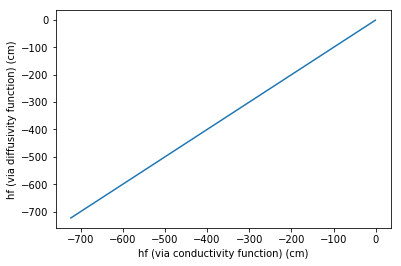

In [97]:
plt.plot(hf_1,hf_2)
plt.xlabel('hf (via conductivity function) (cm)')
plt.ylabel('hf (via diffusivity function) (cm)')

We compare also the suction head at the wetting fron with the initial suction head.

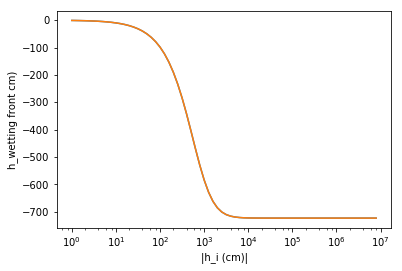

In [98]:
plt.semilogx(np.abs(hi),hf_1,np.abs(hi),hf_2)
plt.xlabel('|h_i (cm)|')
plt.ylabel('h_wetting front cm)')

We also observe that the evaluation of this suction head at the wetting front is the same using either the conductivity or diffusivity weighing.

The suction head at the wetting front is therefore clearly a non-linear function of the initial suction head. It can be considered as a conductivity or diffusivity weighed suction head between the initial suction head and the suction head at saturation ($h=0$). For high initial suction heads (dry soil), the  suction head at the wetting front stabilises to a constant value. 

Let' now implement the Green and Ampt model. As shown in the theoretical course, the Green and Ampt model is an implicit infiltration model and reads as follows:

\begin{equation}
    t=\left( \frac{\theta_s-\theta_i}{k_s}\right)\left(L+(h_f-h_0)ln\left(1-\frac{L}{h0-h_f}\right)\right)
\end{equation}

where $h_0$ (cm), is the ponding height at the surface;  $L$ (cm), is the depth of the infiltration front.

The equation above represents $t$ as a function of $L$. There does not exist a closed form expression of the inverse relationship,  $L$ as a function of $t$. Hence, we need to solve this implicit equation numerically. For doing thism, we substract the right hand term from the left hand term, and for different values of $t$, we look for the roots of the non linear equation in $L$. We use $fsolve$ from the $SciPy$ library to find these roots. 

We should  add a cautionry remark. The solution of this equation is subjected to the conceptual constraints of the Green and Ampt theory, but also to the mathematical constraint that 

\begin{equation}
    1-\frac{L}{h0-h_f}\gt 0
\end{equation}

or

\begin{equation}
    L \lt h0-h_f
\end{equation}

So, far large values of L, this infiltration model can no longer be used. 

In [99]:
def green_ampt(L,t,ths,thi,ks,hf,h0):
    arg=np.max([1-(L/(h0-hf)),0.0])
    return t-(ths-thi)/ks*(L+(hf-h0)*np.log(arg))

hi = -800.
h0 = 0.
dt=0.1
t = np.arange(0.1,1.9,dt)
thi = vgmod(theta_s,theta_r,alfa,n,np.abs(hi))
inte = np.asarray(quad(integrand_cond,0,hi, args=(theta_s,theta_r,alfa,n,ks,lamda)))
hf = inte[0]/ks
L=len(t)*[0]
inst_inf=len(t)*[0]

for i in range(0,len(t)):
    L[i]=fsolve(green_ampt,10,args=(t[i],theta_s,thi,ks,hf,h0))
    inst_inf[i]=-ks*(hf-L[i]-h0)/(L[i])

We make the figures of the calculated instantaneous infiltration rate, and the cumulative infiltration rate:

\begin{equation}
    I=L\left(\theta_s-\theta_i\right)
\end{equation}

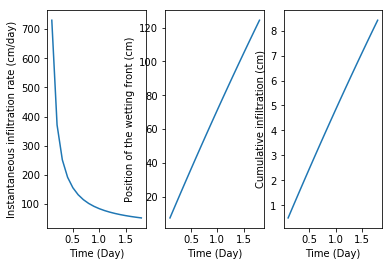

In [100]:
plt.subplot(1,3,1)
plt.plot(t,inst_inf)
plt.xlabel('Time (Day)')
plt.ylabel('Instantaneous infiltration rate (cm/day)')

plt.subplot(1,3,2)
plt.plot(t,L)
plt.xlabel('Time (Day)')
plt.ylabel('Position of the wetting front (cm)')

plt.subplot(1,3,3)
plt.plot(t,np.asarray(L)*(theta_s-thi))
plt.xlabel('Time (Day)')
plt.ylabel('Cumulative infiltration (cm)')

Note that we cannot calculate the cumulative infiltration by a simple numerical integration of the instantaneous infiltration rate because because this integral is unbounded as $t \rightarrow 0$. This is illustrated below: 

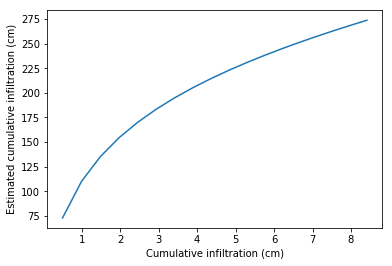

In [101]:
est_inf=np.cumsum(inst_inf)*dt
plt.plot(np.asarray(L)*(theta_s-thi),est_inf)
plt.xlabel('Cumulative infiltration (cm)')
plt.ylabel('Estimated cumulative infiltration (cm)')

This illustartes that the Green and Ampt model, unlike its conceptual simplicity and hence popularity in hydrological applications, suffers from some additional numerical constraints.